In [1]:
import numpy as np
import pandas as pd
from random import *
class NeuralNetwork:
    """Class that creates a NN and includes methods to train and test"""
    def __init__(self, setup=[[68,25,"sigmoid",0],[25,1,"sigmoid",0]],lr=.05,seed=1,error_rate=0,bias=0.5,iters=500,lamb=.00001,simple=0):
        #Note - these paramaters are examples, not the required init function parameters
        self._lr = lr
        self._seed = seed
        self._error_rate = error_rate
        self._bias = bias
        self._iters = iters
        self._lamb = lamb
        self._simple = simple
        

        # network is represented as a list of layers,
        # where layers are a list of nodes, where nodes
        # are a list of weights.
        # weights = [ [[w1,w2...], [w1,w2...]] <- layer1
        #             [[w1,w2...], [w1,w2...]] <- layer2
        #           ]
        weights = []
        outputs = []
        change = []
        
        # initialize the given number of layers with weights
        for layer in setup:
            weights.append(self.make_weights(n_inputs=layer[0],n_nodes=layer[1]))
            outputs.append([0] * layer[1])
            change.append([0] * layer[1])
        
        self._weights = weights
        self._outputs = outputs
        self._change = change
        
    @property
    def lr(self):
        return self._lr

    @lr.setter
    def lr(self, lr):
        self._lr = lr

    @property
    def bias(self):
        return self._bias

    @bias.setter
    def bias(self, bias):
        self._bias = bias 
    
    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed 
    
    @property
    def outputs(self):
        return self._outputs

    @outputs.setter
    def outputs(self, outputs):
        self._outputs = outputs 
        
    @property
    def change(self):
        return self._change

    @change.setter
    def change(self, change):
        self._change = change 
    
    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, weights):
        self._weights = weights 
        
        
    def make_weights(self,n_inputs, n_nodes):
        """
        Generates random weights for the network initialization

        Parameters
        ---------
        n_inputs
            Number of input nodes to this layer
        n_nodes
            Number of nodes to generate weights for
            
        Returns
        ---------
        Layer with random weights initialized for each node
        """
        #seed(self.seed)
        layer = []
        
        # Get n_inputs random float between -1 and 1 for each node
        for i in range(n_nodes):
            node_weights = [uniform(-1, 1) for j in range(n_inputs)]
            node_weights.append(self.bias) # add bias at end
            layer.append(node_weights)
        
        return layer

    def feedforward(self, data):
        """
        Takes in data and passes it through the NN

        Parameters
        ---------
        data
            One datapoint
            
        Returns
        ---------
        The output(s) of the final layer in the network
        """
        inputs = data
        
        # pass data through all layers
        for layer in range(len(self.weights)):
            next_inputs = []
            for node in range(len(self.weights[layer])):
                sum = 0
                for i in range(len(inputs)): # multiply inputs by weights and add to sum
                    sum += inputs[i]*self.weights[layer][node][i]
                    
                sum += self.weights[layer][node][-1] # add bias
                output = sigmoid(sum) # Apply activation function
                self.outputs[layer][node] = output
                next_inputs.append(output)
            inputs = next_inputs
        # inputs should now be the final layer output
        return inputs
    
    def backprop(self, true_values, data):
        """
        Calculates the loss and gradient for each output node.
        Propagates the gradient through the network and records
        the error for each node.
        
        Parameters
        ---------
        true_values
            true classification of example
        data
            training example

        Returns
        ---------
        None, change matrix is filled in for weight updating
        """
        # start at last layer
        for layer in reversed(range(len(self.outputs))): 
            if layer == len(self.outputs) - 1: # for last layer, calculate loss using true values
                for node in range(len(self.outputs[layer])):
                    loss = (true_values[node] - self.outputs[layer][node])
                    # fill in change matrix
                    self.change[layer][node] = loss*sigmoid_derivative(self.outputs[layer][node])
            else: # for all other layers
                for node in range(len(self.outputs[layer])):
                    loss = 0
                    # sum weighted losses from previous layer
                    for prev_layer_node in range(len(self.weights[layer + 1])):
                        loss += self.weights[layer+1][prev_layer_node][node]*self.change[layer+1][prev_layer_node]
                    # fill in change matrix
                    self.change[layer][node] = loss*sigmoid_derivative(self.outputs[layer][node])
         
        
        # Update weights
        for layer in reversed(range(len(self.outputs))): 
            input = data[0] # the input to the first layer is the training example
            if layer != 0: # the input to rest of layers is output of prev layer
                input = [self.outputs[layer-1][node] for node in range(len(self.outputs[layer - 1]))]
            for node in range(len(self.outputs[layer])):
                for i in range(len(input)):
                    self.weights[layer][node][i] += self.lr*self.change[layer][node]*input[i]
                # update bias
                self.weights[layer][node][-1] += self.lr*self.change[layer][node]


    def fit(self, training):
        """
        Trains the neural network and computes training loss.
        After each epoch, computes the training and validation loss.
        
        Parameters
        ---------
        true_values
            a list of true value(s) associated with the current
            training example

        Returns
        ---------
        Dataframe of 
        """
        train_loss = 0
        for row in training:
            output = self.feedforward(row[0])
            expected = row[-1] # Expected value should be last element of training row
            # Sum loss of all output nodes
            train_loss += sum([(expected[i]-output[i])**2 for i in range(len(expected))])
            self.backprop(true_values=expected, data=row)
        return train_loss/len(training)
        
    def predict(self, data):
        return self.feedforward(data)
    

def activation(input, weights):
    pass
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1 - sigmoid(x))

In [2]:
def read_train_seqs(pos_file, neg_file):
    """
    Reads in positive and negative sequences from paths
    into two lists, pos and neg. For negative sequences,
    skips the lines starting with ">"

    Parameters
    ---------
    pos_file
        path to positive examples
    neg_file
        path to negative examples
        
    Returns
    ---------
    two lists, where each element is a sequence from the file
    """
    with open(pos_file) as f:
        pos = f.read().splitlines()
    
    neg = []
    seq = ''
    for line in open(neg_file):
        if line.startswith(">"):
            if seq != '':
                neg.append(seq)
                seq = ''
        else:
            seq += line.strip() 
    neg.append(seq)
    return pos,neg

def encode_seq(sequence):
    """
    Performs one-hot encoding of a nucleotide sequence,
    where each nucleotide is represented by a binary vector
    of length 4, ie: [1, 0, 0, 0], where a 1 corresponds to
    which nucleotide it is: [A, C, G, T]

    Parameters
    ---------
    sequence
        the sequence string to encode
        
    Returns
    ---------
    A one-hot encoded sequence represented as a list of lists,
    each with length 4
    """
    encoded = []
    for nuc in sequence:
        if nuc == 'A':
            encoded+=[1,0,0,0]
        elif nuc == 'C':
            encoded+=[0,1,0,0]
        elif nuc == 'G':
            encoded+=[0,0,1,0]
        elif nuc == 'T':
            encoded+=[0,0,0,1]
    return encoded


In [33]:
def training(pos_batch_size, neg_batch_size, n_epochs, nn):
    losses = pd.DataFrame(columns = ['Epoch', 'Train', 'Validation']) 
    for epoch in range(n_epochs):
        batch_losses = []
        # run through all neg examples while upsampling pos examples
        while neg_queue.empty() == False:
            # get a new batch of positive and neg examples
            neg_batch = [neg_queue.get() for i in range(neg_batch_size)]
            pos_batch = []
            for i in range(pos_batch_size):
                if pos_queue.empty(): # replenesh pos samples when necessary
                    for i in range(len(pos_train)):
                        pos_queue.put(pos_train[i])
                pos_batch.append(pos_queue.get())

            train = neg_batch + pos_batch
            shuffle(train)

            batch_losses.append(nn.fit(train))

        # Average over the batch losses    
        train_loss = sum(batch_losses)/len(batch_losses)

        val_loss = 0
        for val in validation:
            output = nn.predict(val[0])
            expected = val[-1]
            val_loss += sum([(expected[i]-output[i])**2 for i in range(len(expected))])
        losses = losses.append({'Epoch' : epoch, 'Train' : train_loss,
                                'Validation': val_loss/len(validation)}, ignore_index=True)

        # shuffle negative examples and add to queue
        shuffle(neg_train)
        for i in range(len(neg_train)):
            neg_queue.put(neg_train[i])

        shuffle(pos_train)
        pos_queue.queue.clear()
        for i in range(len(pos_train)):
            pos_queue.put(pos_train[i])

    return losses

In [ ]:

def test_make_weights():
    nn = NeuralNetwork(setup=[[8,3,"sigmoid",0],[3,8,"sigmoid",0]])
    assert len(nn.weights) == 2
    assert len(nn.weights[0]) == 3
    assert len(nn.weights[1]) == 8
    assert len(nn.weights[0][0]) == 9
    assert len(nn.weights[1][0]) == 4

def test_feedforward():
    nn = NeuralNetwork([[2,1, "sigmoid",0], [1,2, "sigmoid",0]])
    # a 2x1x2 network
    out = nn.feedforward([1,1])
    assert len(out) == 2
    assert nn.outputs[1] == out
    
def test_encoder():
    assert True

def test_encoder_relu():
    assert True

def test_one_d_ouput():
    assert True

def test_read_train_seqs():
    pos,neg = read_train_seqs(pos_file = "./data/rap1-lieb-positives.txt", neg_file = "./data/yeast-upstream-1k-negative.fa")
    print(len(pos),len(neg))
    assert len(neg) == 3164
    assert len(pos) == 137
    for i in range(len(pos)):
        assert len(pos[i]) == 17

def test_encode_seq():
    seq = 'ACTG'
    encoded = encode_seq(seq)
    assert len(encoded) == 16
    assert encoded == [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]

In [ ]:
test_encode_seq()

## Test autoencoder

In [ ]:
# generate 8 bit binary vectors
identity = list(np.identity(8))

In [ ]:
train = [[list(i),list(i)] for i in identity]
train

In [ ]:
nn = NeuralNetwork([[8,3, "sigmoid",0], [3,8, "sigmoid",0]])

In [ ]:
losses = pd.DataFrame(columns = ['Epoch', 'Train']) 
nn.lr = 0.3
for epoch in range(2000):
    if epoch == 5000:
        nn.lr = 0.05
    loss = nn.fit(train)
    losses = losses.append({'Epoch' : epoch, 'Train' : loss}, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for name in ['Train']:
    ax.plot(losses['Epoch'],losses[name], label=name)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend(loc='best')

In [ ]:
nn.predict([0,0,1,0,0,0,0,0]) 



## Test NN for TF binding

In [3]:
positives, full_negs = read_train_seqs(pos_file="./data/rap1-lieb-positives.txt", neg_file="./data/yeast-upstream-1k-negative.fa")

# just take the last 17 bp of all of the negatives
negatives = [seq[len(seq)-17:len(seq)] for seq in full_negs]
negatives[1:5]

['AAATCTTCACCACCCAA',
 'AGTAAATAACAGATAAT',
 'CATTGTAAAGGAAAACC',
 'AAAATAATAGGTGTAAA']

In [4]:
pos_enc = [[encode_seq(seq),[1]] for seq in positives]


In [5]:
neg_enc = [[encode_seq(seq),[0]] for seq in negatives]

In [6]:
# Put some examples in a validation set. 
# 80/20 split for positives: Since there are only 137 positives, let's save 27 positives.
# Let's just save 64 negs for validation.

pos_test_len = 27
pos_test_idx = sample(range(len(pos_enc)), pos_test_len)
neg_test_len = 64
neg_test_idx = sample(range(len(neg_enc)), neg_test_len)

pos_test = [pos_enc[idx] for idx in pos_test_idx]
neg_test = [neg_enc[idx] for idx in neg_test_idx]

pos_train = [pos_enc[idx] for idx in range(len(pos_enc)) if idx not in pos_test_idx]
neg_train = [neg_enc[idx] for idx in range(len(neg_enc)) if idx not in neg_test_idx]

validation = pos_test + neg_test
shuffle(validation)

In [22]:
import queue

# make two queues
pos_queue = queue.Queue(maxsize=0) 
  
for i in range(len(pos_train)):
    pos_queue.put(pos_train[i])

neg_queue = queue.Queue(maxsize=0) 
  
for i in range(len(neg_train)):
    neg_queue.put(neg_train[i])

In [34]:
nn = NeuralNetwork([[68,25, "sigmoid",0], [25,1, "sigmoid",0]])
nn.lr = 0.05

In [36]:
losses = training(pos_batch_size = 50,neg_batch_size = 155, n_epochs = 50, nn = nn)

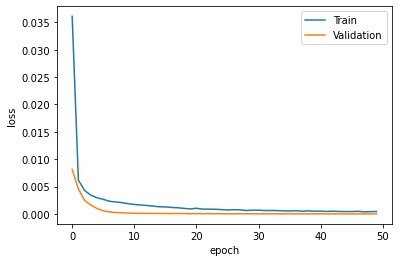

In [37]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for name in ['Train', 'Validation']:
    ax.plot(losses['Epoch'],losses[name], label=name)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend(loc='best')

In [31]:
nn.predict(validation[10][0])

[6.687661466133474e-07]

## Cross Validation

In [ ]:
# Perform a 5-fold cross validation
# There are 3301 total examples, 3164 neg and 137 pos
# Need to class balance folds, so just split both pos and neg into 5 folds, then combine to form a fold
# (last fold contains the rest if uneven)
# Need to class balance the folds. 
k = 5
# n examples to include in each fold
n_pos_folds = len(pos_enc)/k
n_neg_folds = len(neg_enc)/k

for i in range(k):
    if i == k: # for the last fold, use all remaining data
        pos_val = pos_enc[i*n_pos_folds:]
        neg_val = neg_enc[i*n_neg_folds:]
        validation = pos_val + neg_val
        shuffle(validation)
    else:
        pos_val = pos_enc[i*n_pos_folds:i*n_pos_folds+n_pos_folds]
        neg_val = neg_enc[i*n_neg_folds:i*n_neg_folds+n_neg_folds]
        validation = pos_val + neg_val
        shuffle(validation)
    # train is just all examples minus the fold
    pos_train = [:i*n_pos_folds]
    neg_train = [:i*n_neg_folds]

In [41]:
l = [1,2,3]
l[0:]

[1, 2, 3]

In [ ]:
# Start with all pos and neg examples
# for each fold
    # put fold in in test, the rest in train
    # run training
    # actual = []
    # actual.append(test set )
    # output pred

In [ ]:
# Get fpr, tpr, and auc for each model
result_table = pd.DataFrame(columns=['score_mat', 'fpr','tpr','auc'])

i = 1
for pred,actual in folds.items():  
    fpr, tpr, _ = roc_curve(actual,  pred)
    auc = roc_auc_score(actual, pred)
    
    result_table = result_table.append({'k': i,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    i+=1
result_table

In [ ]:
# ROC 
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()